In [88]:
import requests
import json
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates
from matplotlib import style
%matplotlib notebook

In [89]:
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.76 Safari/537.36',
           'referer':"https://www.nseindia.com/products/content/equities/equities/eq_security.htm" } 

In [90]:
def get_symbol_count(symbol):
    symbol = symbol.upper()
    sym_count = "https://www.nseindia.com/marketinfo/sym_map/symbolCount.jsp"
    sym_count_pl = {"symbol":symbol}
    sym_count_request = requests.get(sym_count, params = sym_count_pl)
    symbol_count  = int(sym_count_request.content.strip())
    return symbol_count

In [105]:
def get_3_month(symbol):
    symbol = symbol.upper()
    link = "https://www.nseindia.com/products/dynaContent/common/productsSymbolMapping.jsp"
    payload = { "symbol":symbol,"segmentLink":3,"symbolCount":get_symbol_count(symbol),
            "series":"EQ","dateRange":"3month",
            "fromDate":"","toDate":"","dataType":"PRICEVOLUME"}
    with requests.Session() as s:
        r = s.get(link, params = payload, headers=headers)
    data = pd.read_html(r.content, header=0)[0]
    colnames = {
                'Symbol':"sym", 'Series':"ser", 'Date':"date", 
                'Prev Close':"pc", 'Open Price':"o", 'High Price':"h",
                'Low Price':"l", 'Last Price':"ltp", 'Close Price':"c", 
                'Average Price':"ap",'Total Traded Quantity':"totalqty", 
                'Turnover':"turnover",'No. of Trades':"trades", 
                'Deliverable Qty':"delqty",'% Dly Qt to Traded Qty':"delbytotal"
               }
    data.rename(columns = colnames, inplace = True)
    data['sma5'] = data.c.rolling( window = 5).mean()
    data['sma8'] = data.c.rolling( window = 8).mean()
    data['change'] = data.c.diff()
    data["date"] = pd.to_datetime(data.date)
    data = data.sort_values(by = ["date"])
    data = data.set_index(pd.DatetimeIndex(data["date"]))
    data['sma5'] = data.c.rolling( window = 5).mean()
    data['sma8'] = data.c.rolling( window = 8).mean()
    data['change'] = data.c.diff()
    data['ema12'] = data.c.ewm(span=12, min_periods = 12, adjust=True).mean()
    data['ema26'] = data.c.ewm(span=26, min_periods = 26, adjust=True).mean()
    data['macd']  = data['ema12'] - data['ema26']
    data['sig'] = data['macd'].ewm(span=9, min_periods = 9, adjust=True).mean()
    data['bars']  = data['macd']-data['sig']
    return data

In [106]:
def plot_ohlc(symbol):
    style.use('ggplot')
    df = get_3_month(symbol)
    df['date'] = df.index.map(mdates.date2num)
    ohlc = df[['date','o','h','l','c']]
    f1, ax = plt.subplots(figsize = (10,5))
    # plot the candlesticks
    candlestick_ohlc(ax, ohlc.values, width=.6, colorup='green', colordown='red')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    plt.title("HAPPY")
    plt.show()

<IPython.core.display.Javascript object>


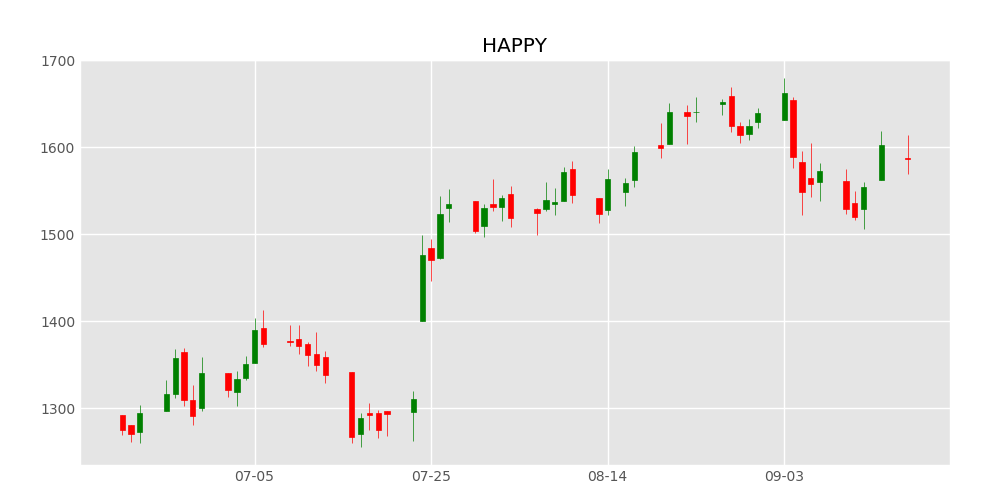

In [107]:
plot_ohlc("ACC")